# Исследование поведения пользователей мобильного приложения. 
# Анализ А/A/В - теста.

**Описание проекта**

Проект посвящен мобильному приложению стартапа, продающему продукты питания. 

Исследуем поведение пользователей мобильного приложения.

Изучим воронку продаж: 
- узнаем, как пользователи доходят до покупки
- сколько пользователей доходит до покупки
- сколько пользователей «застревает» и на каких этапах?

Исследуем результаты A/A/B-эксперимента, где  2 контрольные группы со старыми шрифтами и одна экспериментальная — с новыми шрифтами в приложении. Выясним, какой шрифт лучше.

В ходе анализа будем исследовать качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.

**Описание данных**

Каждая запись в логе — это действие пользователя, или событие.

- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

**Структура проекта**

1  Импорт и ознакомление с данными
- Загрузка библиотек и данных
- Изучение общей информации
- Вывод

2  Подготовка данных.
- Фильтрация дубликатов и замена названий.
- Добавление сведений о дате и времени
- Вывод

3  Изучение и проверка данных
- Подсчет событий, пользователей и среднего числа событий пользователя
- Изучение периода наблюдений
- Вывод

4  Исследование воронки событий
- Анализ видов и частоты событий в логах
- Число и доля пользователей по видам событий
- Анализ воронки продаж
- Вывод

5  Анализ результатов эксперимента
- Исследование числа участников и чистоты распределения групп
- Исследование различий контрольных групп.
- Исследования различий контрольных и тестовой группы
- Вывод

6  Выводы

## Импорт и ознакомление с данными

### Загрузка библиотек и данных

Загрузим необходимые библиотеки, настроим форматы отображения данных.

In [1]:
import pandas as pd
import numpy as np
import math as mth
import seaborn as sns
import datetime as dt
from datetime import timedelta, datetime
import matplotlib
from matplotlib import pyplot as plt
from plotly import graph_objects as go
import functools
from scipy import stats as st

# настраиваем количество знаков после запятой
pd.set_option('display.float_format', '{:.2f}'.format)

Импортируем данные

In [2]:
df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

### Изучение общей информации

Ознакомимся с данными. Напишем фукнцию для вывода основных сведений о сете.

In [3]:
def inspection(data):
    display(data.head()) 
    print(50*'*')
    data.info() 
    print(50*'*')
    print ('Количество дубликатов -', data.duplicated().sum())
    print(50*'*')
    numeric_columns=data.describe().columns
    for column_name in data.columns:
        if column_name not in numeric_columns:
            if 'id' not in column_name and 'time' not in column_name:
                display(data[column_name].value_counts())
                print(50*'*')
    return data.sample()
inspection(df)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
**************************************************
Количество дубликатов - 413
**************************************************


MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: EventName, dtype: int64

**************************************************


,EventName,DeviceIDHash,EventTimestamp,ExpId
61027,OffersScreenAppear,1501007085405726211,1564756577,246


### Вывод

- В сете 244126 записей. 
- Из них 413 явных дубликатов. 
- Пропусков значений нет. 
- Дата события предположительно в формате UNIX.
- Присутствует 5 видов событий (в порядке уменьшения количества появления): 
     - страница главного экрана;
     - страница предложений;
     - страница корзины;
     - страница успешной оплаты;
     - справка.    

## Подготовка данных.

### Фильтрация дубликатов и замена названий.

Удалим дубликаты и переименуем колонки для удобства дальнейшего обращения с ними. 

Здесь и далее приравняем уникальный идентификатор устройства к уникальному пользователю, поскольку других данных для идентификации одного и того же пользователя, зашедшего с разных устройств, у нас нет. 

In [4]:
df.drop_duplicates().reset_index(drop=True)
df.columns = ['event_name', 'user_id', 'timestamp', 'group']
df.sample(5)

,event_name,user_id,timestamp,group
107314,MainScreenAppear,3286987355161301427,1564867330,248
38796,PaymentScreenSuccessful,1872978591788881482,1564700287,247
240523,OffersScreenAppear,4257848154605915902,1565202372,247
77616,MainScreenAppear,8006780413564552457,1564812380,246
117897,PaymentScreenSuccessful,3980203365390854445,1564913353,248


### Добавление сведений о дате и времени

В отдельном столбце переведем данные о дате и времени в стандартный формат datetime до секунд. Выделим дату события в столбец 'date'

In [5]:
df['datetime'] = pd.to_datetime(df['timestamp'], unit="s")
df['date'] = df['datetime'].dt.date
df.tail(5)

,event_name,user_id,timestamp,group,datetime,date
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07
244125,OffersScreenAppear,5746969938801999050,1565212517,246,2019-08-07 21:15:17,2019-08-07


### Вывод

В логах 
- удалены дубликаты;
- стобцы переименованы в соответствии с содержимым;
- добавлень столбец с датой и временем в стандартном формате;
- выделен столбец дат.

## Изучение и проверка данных 

### Подсчет событий, пользователей и среднего числа событий пользователя

Подсчитаем число уникальных событий, пользователей и групп. 

In [6]:
df[['event_name', 'user_id', 'group']].nunique()

event_name       5
user_id       7551
group            3
dtype: int64

В логах представлено 5 видов событий, 7551 уникальный пользователь, распределенный по трем группам (2 контрольные и 1 тестовая).

Рассчитаем среднее количество событий на одного пользователя.

In [7]:
user_events = df.groupby(['user_id', 'date'], as_index=False).agg({'event_name': ['count', 'first']})
user_events.columns = ['user_id', 'date', 'event_count', 'first_event_name']
display (user_events[['event_count']].describe().T)

,count,mean,std,min,25%,50%,75%,max
event_count,27226.00,8.97,23.02,1.00,3.00,5.00,10.00,2190.00


- Количество событий на одного пользователя варьирует от 1 до 2308
- Среднее количество событий на одного пользователя - 32,33
- Медианное количество событий на пользователя - 20

Проверим, какого рода единичные события присутствуют в сете.

In [8]:
user_events.query('event_count == 1')['first_event_name'].value_counts()

MainScreenAppear           2819
OffersScreenAppear          366
CartScreenAppear             67
Tutorial                     11
PaymentScreenSuccessful       5
Name: first_event_name, dtype: int64

Основная масса единичных действий пользователя - открытие главной страницы. Однако присутствуют и такие пользователи, которые посетили за исследуемый период исключительно страницу предложений / корзину / справку и даже страницу успешной оплаты.

Необходимы разъяснения коллег по поводу специфики мобильного приложения: возможно ли технически, чтобы первым и единственным действием пользователя было посещение страницы предложений, корзины, справки или успешной оплаты, либо же здесь кроется ошибка. Возможно, что это остаточные действия сессий, начавшихся до периода наблюдений. 

### Изучение периода наблюдений

Рассмотрим подробнее представленный период.

In [9]:
print(df['date'].min())
print(df['date'].max())
print(df['datetime'].max() - df['datetime'].min())

2019-07-25
2019-08-07
13 days 16:31:41


В логах данные с 25-07-2019 по 07-08-2019 за 13 дней, 16 часов, 31 минуту и 41 секунду.

Рассмотрим распределение событий по дням. Построим таблицу и гистрограмму

In [10]:
df.groupby('date').agg({'event_name': 'count'})

,event_name
date,
2019-07-25,9
2019-07-26,31
2019-07-27,55
2019-07-28,105
2019-07-29,184
2019-07-30,413
2019-07-31,2031
2019-08-01,36229
2019-08-02,35606


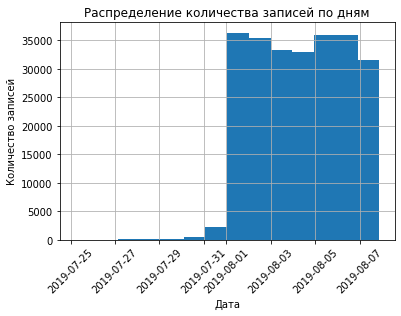

In [11]:
df['datetime'].hist(bins=14)
plt.title('Распределение количества записей по дням')
plt.xlabel('Дата')
plt.ylabel('Количество записей')
plt.xticks(rotation=45);

Судя по таблице и гистограмме до 01-08-2019 в сет попадали остаточные сведения от предыдущих активностей пользователей: событий значительно меньше, чем в последующие дни. Следовательно, полноценный анализ можно осуществлять лишь на основе данных с 01-08-2019 по 07-08-2019.

Число событий в последний день наблюдений тоже немного меньше, чем в другие дни. Определим максимальное время получения информации в последний день наблюдений:

In [12]:
df['datetime'].max()

Timestamp('2019-08-07 21:15:17')

В данных за 07-08-2019 не достает 2 часов и 45 минут наблюдений. Однако количество данных отличается от стандартного не сильно (активность пользователей снижена поздним вечером). Поэтому оставим для изучения данные этого дня.

Исследуем процентное соотношение в сете данных до 01-08-2019 и после. 

In [13]:
date_check = datetime(2019, 8, 1).date()
print ('{:.2%} записей приходится на период 25.07.2019 по 31.07.2019'
       .format(len(df.query('date < @date_check')) / len(df)))
print ('{:.2%} уникальных пользователей использовали приложение в этот период'
       .format(df.query('date < @date_check')['user_id'].nunique() / df['user_id'].nunique()))
print ('{:.2%} уникальных пользователей использовали приложение исключительно в этот период'
       .format((df['user_id'].nunique() - df.query('date >= @date_check')['user_id'].nunique()) / df['user_id'].nunique()))


1.16% записей приходится на период 25.07.2019 по 31.07.2019
19.22% уникальных пользователей использовали приложение в этот период
0.23% уникальных пользователей использовали приложение исключительно в этот период


Таким образом лишь чуть более 1% записей приходится на первую неделю. В них 19% уникальных пользователей, но почти все они заходили в приложение и позже. 

Исключим из анализа период до 01-08-2019, поскольку информация за этот период не является полной. Подобная фильтрация не грозит потерей значимой части информации.

Убедимся, что пользователи всех групп присутствуют в оставшейся части сета.

In [14]:
df2 = df[df['date'] >= date_check]
df2_groups = df2.groupby('group').agg({'user_id': 'nunique'})
df2_groups

,user_id
group,
246,2484
247,2513
248,2537


В оставшихся данных за период 01-08-2019 - 07-08-2019 уникальные пользователи присутствуют во всех трех группах практически в равном количестве. 

Узнаем, избавило ли ограничение по времени наблюдений от единственных событий пользователя, отличных от посещения главного экрана. 

In [15]:
user_events2 = df2.groupby(['user_id', 'date'], as_index=False).agg({'event_name': ['count', 'first']})
user_events2.columns = ['user_id', 'date', 'event_count', 'first_event_name']
user_events2.query('event_count == 1')['first_event_name'].value_counts()

MainScreenAppear      2031
OffersScreenAppear     182
Tutorial                 7
CartScreenAppear         5
Name: first_event_name, dtype: int64

Случаи, когда единственное действие пользователя - открытие страницы предложений, справки или корзины, уменьшились по количеству, но все равно присутствуют. Из единственных действий пользователей исчезла лишь страница успешной оплаты. Предположим, что существует техническая возможность начинать работу с остальных страниц и не будем исключать подобные примеры из сета. 

### Вывод

- В данных присутствуют:
        - 7551 уникальный пользователь
        - 5 видов событий 
        - 3 группы (2 контрольных и 1 тестовая)
        - события за период 25-07-2019 - 07-08-2019
- Распределение событий по дням неравномерно: до 31-07-2019 включительно максимальное число событий в день существенно меньше, чем в последующие дни (2031 против 31144). Предположительно это технические особенности сбора данных, в ходе которых в исследуемый период дописывались данные предыдущих дней. Следовательно, период до 01-08-2019 исключаем из анализа с потерей 1% строк.
- Изучаемый период составит 7 дней: 01-08-2019 - 07-08-2019
- В данных присутствуют пользователи, единственным действием которых в изучаемом периоде является открытие страницы предложений, корзины или справки. Оставим эти данные в сете, предположив, что технически существует возможность открытия приложения на любой странице. 

## Исследование воронки событий

### Анализ видов и частоты событий в логах

Как уже было рассмотрено при первичном обзоре данных, в логах 5 видов событий, по частоте встречаемости расположенных следующим образом: 
- страница главного экрана (119205 событий данного вида);
- страница предложений (46825);
- страница корзины (42731);
- страница успешной оплаты (34313);
- справка (1052).

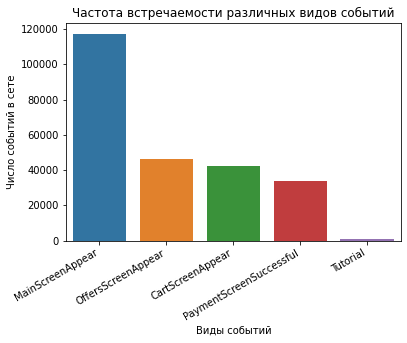

In [16]:
df_event_count = df2.groupby('event_name', as_index=False).agg({'user_id':'count'})
df_event_count.columns = ['event_name', 'event_count']
df_event_count = df_event_count.sort_values(by='event_count', ascending=False)
fig = sns.barplot(x='event_name', y='event_count', data=df_event_count)
fig.set_title('Частота встречаемости различных видов событий')
fig.set_xlabel('Виды событий')
fig.set_ylabel('Число событий в сете')
plt.xticks(rotation=30, horizontalalignment='right');

Частота посещения главного экрана приложения более, чем в 2 раза превышает частоту использования страницы предложения. Тогда как обращений к странице корзины почти столько же, сколько посещений страницы предложения. Число обращений к справке незначительно. 

### Число и доля пользователей по видам событий

Посчитаем число уникальных пользователей, совершивших событие каждого вида хотя бы 1 раз в исследуемый период

In [17]:
df_funnel = df2.groupby('event_name', as_index=False).agg({'user_id': ['count', 'nunique']})
df_funnel.columns=['event_name', 'event_count', 'unique_user_count']
df_funnel = df_funnel.sort_values(by='unique_user_count', ascending=False).reset_index(drop=True)
df_funnel['users_rate'] = df_funnel['unique_user_count'] / df_funnel.loc[0, 'unique_user_count']
df_funnel

,event_name,event_count,unique_user_count,users_rate
0,MainScreenAppear,117431,7419,1.00
1,OffersScreenAppear,46350,4593,0.62
2,CartScreenAppear,42365,3734,0.50
3,PaymentScreenSuccessful,34113,3539,0.48
4,Tutorial,1039,840,0.11


Стандартной последовательностью взаимодействия пользователя с приложением в ходе покупки является следующая:
- Страница главного экрана;
- Страница предложения;
- Страница корзины;
- Страница успешной оплаты.

Страница справки не является заключительным этапом. К ней пользователь может обращаться после любого другого события или даже в первую очередь, поэтому исключим строку с количеством пользователей, открывавших справочную информацию и построим воронку по значимым событиям, ведущим пользователя к успешной покупке.

### Анализ воронки продаж 

Построим воронку с автоматическим рассчетом процента пользователей, перешедших на каждый следующий этап. 

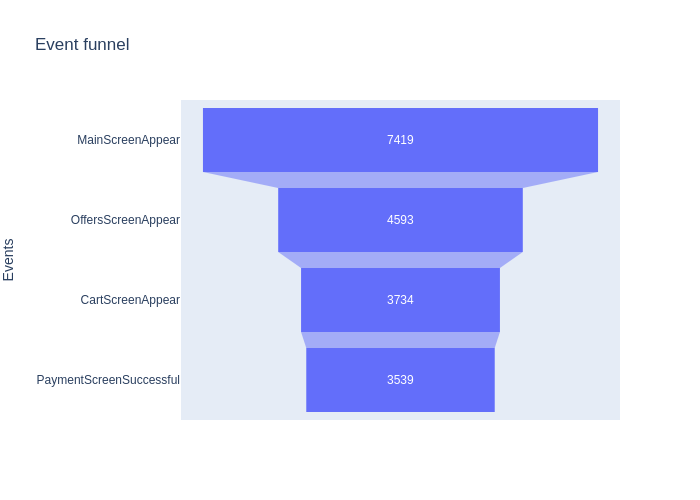

In [18]:
df_funnel = df_funnel.loc[:3]
fig = go.Figure(go.Funnel(y=df_funnel['event_name'], x=df_funnel['unique_user_count']))
fig.update_layout(title='Event funnel',
                  yaxis_title='Events')
fig.show('png')

figure.png

Из представленного графика видно, что самое большое число пользователей - 38% - теряется после главной страницы, 18,7% не переходят от предложения к корзине. Наименьшие потери при переходе от корзины к успешной оплате. Значит, технических проблем с оплатой у пользователей не возникает. 

От общего числа посетителей главной страницы 62% открывают предложения, 50,4% переходят в корзину и 47,7% успешно ее оплачивают. 

Таким образом, до успешной оплаты заказа доходит 47,7% пользователей, зашедших в приложение, а наибольшие потери происходят на этапе перехода от главной страницы к предложению.

### Вывод

* В сете 5 видов событий, по частоте встречаемости расположенных следующим образом: главная страница, страница предложений, страница корзины, страница успешной оплаты, справка. 
* Справочная информация не является заключительным этапом воронки продаж, поэтому исключена из нее. 
* Наиболее количество покупателей (38%) "отваливается" после посещения главной страницы. Вероятно, на главном экране приложения не хватает уникального торгового предложения и/или призывов к действию, мотивирующих пользователей переходить к покупкам. Изменения главной страницы могут стать основой следующего А/В-теста.  
* Существенное количество пользователей (18,7%) не переходит от предложения к корзине. Здесь необходимы дополнительные исследования-опросы, чего именно не нашел пользователь среди предложений сайта. Можно осуществить данный опрос при помощи e-mail - рассылки для клиентов или добавить опрос на саму страницу предложения. Возможно, необходимо расширение ассортимента и/или улучшение навигации по предложениям. 
* Наименьшие потери пользователей происходят при переходе от корзины к успешной оплате. Следовательно, пользователи практически не забывают о своих корзинах, удовлетворены предложенными условиями оплаты и не сталкиваются с техническими сложностями. Для повышения эффективности конверсии из корзины в покупку можно использовать e-mail рассылку о забытой корзине (если это еще не реализовано), а также мониторинг ошибок, возникающих в ходе взаимодействия.
* 47,7% пользователей, зашедших в приложение, успешно совершает в нем покупку. 

## Анализ результатов эксперимента

### Исследование числа участников и чистоты распределения групп

Убедимся, что сортировка прошла успешно и в каждой группе свои уникальные пользователи.

In [19]:
users_group = df2.groupby('group').agg({'user_id': 'nunique'})
users_group.T

group,246,247,248
user_id,2484,2513,2537


Рассчитаем, на сколько процентов отличается количество уникальных пользователей контрольных групп.

In [20]:
print ('Число уникальных пользователей контрольных групп отличается на {:.2%}'
       .format((df2_groups.loc[247, 'user_id'] 
                - df2_groups.loc[246, 'user_id']) 
               / df2_groups.loc[246, 'user_id']))

Число уникальных пользователей контрольных групп отличается на 1.17%


Полученный результат не является идеальным, но близок к допустимой разнице между контрольными группами в 1%.

Проверим соответствие числа уникальных пользователей исследуемого сета и суммы уникальных пользователей по группам.

In [21]:
print ('''Разница между суммой уникальных пользователей в группах 
и числом уникальных пользователей всего сета -''',
df2['user_id'].nunique() - users_group['user_id'].sum())

Разница между суммой уникальных пользователей в группах 
и числом уникальных пользователей всего сета - 0


Проведем дополнительную проверку и убедимся, что уникальные пользователи каждой группы в сете упоминаются только в этой группе. 

In [22]:
group_numbers = df['group'].unique()
for x in group_numbers:
    df_group = df2[df2['group'] == x]
    group_list= df_group['user_id'].unique()
    print (df2.query('user_id in @group_list')['group'].unique())

[246]
[248]
[247]


Рассмотрим общее количество событий пользователей в разных группах и их распределение. 

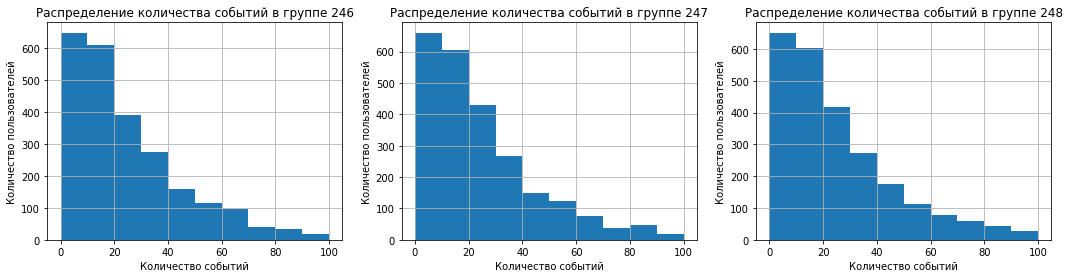

In [23]:
plt.figure(figsize=(18, 4))

ax1 = plt.subplot(1, 3, 1)
df_group_246 = df2.query('group == 246')
df_group_246.groupby('user_id', as_index=False).agg({'event_name': 'count'})['event_name'].hist(range=(0, 100))
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей')
plt.title('Распределение количества событий в группе 246');

ax2 = plt.subplot(1, 3, 2)
df_group_247 = df2.query('group == 247')
df_group_247.groupby('user_id', as_index=False).agg({'event_name': 'count'})['event_name'].hist(range=(0, 100))
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей')
plt.title('Распределение количества событий в группе 247');

ax3 = plt.subplot(1, 3, 3)
df_group_248 = df2.query('group == 248')
df_group_248.groupby('user_id', as_index=False).agg({'event_name': 'count'})['event_name'].hist(range=(0, 100))
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей')
plt.title('Распределение количества событий в группе 248');

Распределение количества событий по пользователям разных групп является примерно одинаковым. Во всех случаях есть пользователи с аномально высоким числом событий.

### Исследование различий контрольных групп.

Напишем функцию для подсчета долей уникальных пользователей, участвовавших в каждом событии, и анализа статистической значимости различия в долях между группами. 

Анализ числа обращений к справочной информации тоже может быть полезен, как показатель того, не стало ли приложение менее интуитивно понятнее для пользователей. Поэтому не будем исключать данные о посещениях справочной страницы из анализа.

In [24]:
def share_comparison (df_xgroup, df_ygroup, alpha):
    # для каждой из анализируемых групп 
    # создадим группировку по видам событий и 
    # подсчитаем количество и долю уникальных пользователей 
    xgroup_events = (df_xgroup
                     .groupby('event_name', as_index=False)
                     .agg({'user_id':'nunique'})
                     .sort_values(by='user_id', ascending=False)
                     .reset_index(drop=True))
    # переименуем столбцы
    xgroup_events.columns = ['event_name', 'uniq_users']
    # посчитаем долю пользователей для каждого вида событий
    xgroup_events['users_rate'] = (xgroup_events['uniq_users']
                                   /xgroup_events.loc[0, 'uniq_users'])
    # повторим процедуру для второй группы
    ygroup_events = (df_ygroup
                     .groupby('event_name', as_index=False)
                     .agg({'user_id':'nunique'})
                     .sort_values(by='user_id', ascending=False)
                     .reset_index(drop=True))
    ygroup_events.columns = ['event_name', 'uniq_users']
    ygroup_events['users_rate'] = (ygroup_events['uniq_users']
                                   /ygroup_events.loc[0, 'uniq_users'])
    # объединим два фрейма с информацией о долях уникальных пользователей, участвовавших в каждом событии
    groups_merge = xgroup_events.merge(ygroup_events, 
                                       on='event_name', 
                                       how='left')
    display (groups_merge)
    
    alpha = alpha #критический уровень статистической значимости

    for n in range(4):
        # формируем множество, отражающее успех в каждой из двух групп
        purchases = np.array([groups_merge.loc[n+1, 'uniq_users_x'], groups_merge.loc[n+1, 'uniq_users_y']])
        # формируем множество, отражающее попытки в каждой из двух групп
        leads = np.array([groups_merge.loc[n, 'uniq_users_x'], groups_merge.loc[n, 'uniq_users_y']])
        # пропорция успехов в первой группе
        p1 = purchases[0]/leads[0]
        # пропорция успехов во второй группе
        p2 = purchases[1]/leads[1]
        # пропорция успехов в комбинированном датасете
        p_combined = (purchases[0] + purchases[1]) / (leads[0] + leads[1])
        # разница пропорций в датасетах
        difference = p1 - p2
        # считаем статистику в стандартных отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1-p_combined) * (1/leads[0] + 1/leads[1]))
        # задаем стандартное нормальное распределение (среднее 0, ст. отклонение 1)
        distr = st.norm(0, 1)
        
        # расчитываем значимую вероятность, исходя из того, что
        # H0 - доли групп не отличаются, H1 - доли групп отличаются
        p_value = (1-distr.cdf(abs(z_value))) * 2
        # описываем вывод
        print (f'Отличия в долях конверсии строки {n} в следующий этап. P-значение:', p_value)
        if p_value < alpha:
            print ('Отвергаем нулевую гипотезу: между долями долями групп есть значимая разница')
            print (80*"-")
        else:
            print ('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
            print (80*"-")
    return print (80*"-")

Применим функцию для анализа различия долей в контрольных группах. Поскольку объемы выборок > 100 пользователей, то порог отклонения нулевой гипотезы целесообразно снизить до α=0,01 и принимать решение о наличии различий при р ≤ 0,01. В таком случае лишь в 1 случае из 100 может быть случайно обнаруженно различие, которого нет в данных. Т.е. имеется лишь 1 шанс из 100 ошибиться.

In [25]:
share_comparison(df_group_246, df_group_247, .01)

,event_name,uniq_users_x,users_rate_x,uniq_users_y,users_rate_y
0,MainScreenAppear,2450,1.00,2476,1.00
1,OffersScreenAppear,1542,0.63,1520,0.61
2,CartScreenAppear,1266,0.52,1238,0.50
3,PaymentScreenSuccessful,1200,0.49,1158,0.47
4,Tutorial,278,0.11,283,0.11


Отличия в долях конверсии строки 0 в следующий этап. P-значение: 0.2622344959255778
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------------------------------------
Отличия в долях конверсии строки 1 в следующий этап. P-значение: 0.6393754713145263
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------------------------------------
Отличия в долях конверсии строки 2 в следующий этап. P-значение: 0.18243439408067652
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------------------------------------
Отличия в долях конверсии строки 3 в следующий этап. P-значение: 0.46833167209360305
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------------------------------------
--------------------------

Для контрольных групп на уровне значимости 0,01 не существует  различий в долях пользователей, перешедших на каждый следующий этап воронки. Также не существует различий в долях пользователей, воспользовавшихся справочной информацией. 

С учетом предыдущей информации о чистоте распределения и отклонении числа уникальных пользователей в группах на 1,17% можно говорить об успешности проведенного А/А-теста и разделения пользователей по группам. 

### Исследования различий контрольных и тестовой группы

Сравним теперь каждую из контрольных групп с тестовой, используя ту же функцию и тот же уровень значимости, учитывая, что в используемой функции нулевая и альтернативная гипотеза следующие:
* H0 - доли групп статистически значимо не отличаются
* H1 - доли групп статистически значимо различаются

In [26]:
share_comparison (df_group_246, df_group_248, .01)

,event_name,uniq_users_x,users_rate_x,uniq_users_y,users_rate_y
0,MainScreenAppear,2450,1.00,2493,1.00
1,OffersScreenAppear,1542,0.63,1531,0.61
2,CartScreenAppear,1266,0.52,1230,0.49
3,PaymentScreenSuccessful,1200,0.49,1181,0.47
4,Tutorial,278,0.11,279,0.11


Отличия в долях конверсии строки 0 в следующий этап. P-значение: 0.2684281587249231
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------------------------------------
Отличия в долях конверсии строки 1 в следующий этап. P-значение: 0.2112170818054686
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------------------------------------
Отличия в долях конверсии строки 2 в следующий этап. P-значение: 0.14295341270419004
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------------------------------------
Отличия в долях конверсии строки 3 в следующий этап. P-значение: 0.7920938967629971
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------------------------------------
---------------------------

Для контрольной группы 246 и тестовой группы 248 не существует статистически значимых отличий (для уровня значимости 0,01) в долях пользователей, перешедших на каждый следующий уровень воронки продаж. Также не являются статистически значимыми различия в долях пользователей, открывших справочную информацию. 

Исследуем значимость отличия долей пользователей для контрольной группы 247 и тестовой 248, учитывая, что в используемой функции нулевая и альтернативная гипотеза следующие:

* H0 - доли групп статистически значимо не отличаются
* H1 - доли групп статистически значимо различаются

In [27]:
share_comparison (df_group_247, df_group_248, .01)

,event_name,uniq_users_x,users_rate_x,uniq_users_y,users_rate_y
0,MainScreenAppear,2476,1.00,2493,1.00
1,OffersScreenAppear,1520,0.61,1531,0.61
2,CartScreenAppear,1238,0.50,1230,0.49
3,PaymentScreenSuccessful,1158,0.47,1181,0.47
4,Tutorial,283,0.11,279,0.11


Отличия в долях конверсии строки 0 в следующий этап. P-значение: 0.9869365252844515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------------------------------------
Отличия в долях конверсии строки 1 в следующий этап. P-значение: 0.4364903513062255
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------------------------------------
Отличия в долях конверсии строки 2 в следующий этап. P-значение: 0.005677465395736325
Отвергаем нулевую гипотезу: между долями долями групп есть значимая разница
--------------------------------------------------------------------------------
Отличия в долях конверсии строки 3 в следующий этап. P-значение: 0.6447626122251844
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------------------------------------
----------------------------

При сравнении долей контрольной 247-ой группы и тестовой 248-ой были обнаружены значимые (для уровня статистической значимости, равного 0,01) различия в долях пользователей, перешедших от страницы корзины к странице оплаты. В остальных долях не обнаржено статистически значимых отличий.

Рассмотрим подробнее процент пользователей, перешедших от корзины к успешной оплате в группах 247 и 248. 

In [28]:
print ('Конверсия перехода от корзины к успешной оплате в контрольной группе 247 составила {:.2%}'.format(1158/1238))
print ('Конверсия перехода от корзины к успешной оплате в тестовой группе 248 составила {:.2%}'.format(1181/1230))

Конверсия перехода от корзины к успешной оплате в контрольной группе 247 составила 93.54%
Конверсия перехода от корзины к успешной оплате в тестовой группе 248 составила 96.02%


Таким образом, на текущем этапе можно сказать, что, если изменение шрифта и повлияло на пользователей, то лишь в положительную сторону, увеличив вероятность перехода от корзины к успешной оплате. Хотя следует отметить, что найденные различия могут быть тем 1% ошибки, которую мы допускаем, принимая текущий уровень значимости теста. 

Сравним обе контрольные группы (246 и 247) с тестовой (248), помня, что в используемой функции нулевая и альтернативная гипотеза следующие:

* H0 - доли групп статистически значимо не отличаются
* H1 - доли групп статистически значимо различаются

In [29]:
df_control = df.query('group == 246 or group == 247')

In [30]:
share_comparison (df_control, df_group_248, .01)

,event_name,uniq_users_x,users_rate_x,uniq_users_y,users_rate_y
0,MainScreenAppear,4938,1.00,2493,1.00
1,OffersScreenAppear,3075,0.62,1531,0.61
2,CartScreenAppear,2510,0.51,1230,0.49
3,PaymentScreenSuccessful,2362,0.48,1181,0.47
4,Tutorial,565,0.11,279,0.11


Отличия в долях конверсии строки 0 в следующий этап. P-значение: 0.4707418337312781
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------------------------------------
Отличия в долях конверсии строки 1 в следующий этап. P-значение: 0.2925470663179588
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------------------------------------
Отличия в долях конверсии строки 2 в следующий этап. P-значение: 0.013890962893988723
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------------------------------------
Отличия в долях конверсии строки 3 в следующий этап. P-значение: 0.8452307002479922
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------------------------------------
--------------------------

По совокупности двух контрольных групп на уровне значимости 0,01 не существует статистически значимых различий в долях пользователей, перешедших на каждый следующий этап воронки. Что также немаловажно, не существует значимых различий в долях пользователей, воспользовавшихся справочной информацией. Таким образом, на текущих наблюдениях можно сделать вывод о том, что изменение шрифта не повлияло значимым образом на поведение пользователей.

### Вывод

Разделение на группы произведено успешно:
* Пользователи уникальны для каждой группы. В исследуемом периоде число уникальных пользователей каждой группы составило около 2,5 тыс. Различие числа пользователей между контрольными группами - 1.17% - является близким к допустимому.
* Распределение количества событий для пользователей разных групп визуально похожи.
* Для контрольных групп на уровне значимости 0,01 не существует статистически значимых различий в долях пользователей, перешедших на каждый следующий этап воронки. Также не существует различий в долях пользователей, воспользовавшихся справочной информацией.

Анализ равенства долей, проведенный при помощи кумулятивной функции распределения, дает основания полагать, что изменение шрифта не повлияло значимым образом на поведение пользователей:
- На уровне критической значимости, равном 0,01, не обнаружено отличий долей при переходе от одного этапа воронки продаж к следующему (минимальные отличия в сторону увеличения возможны при переходе от корзины к успешной оплате).
- Не существует значимых различий в долях пользователей, воспользовавшихся справочной информацией. Следовательно, изменение шрифта не повлияло на легкость восприятия информации пользователями и не затруднило и не облегчило взаимодействие с приложением. 

Подобные результаты текущего анализа позволяют предположить, что шрифт приложения можно сменить на предложенный тестовой группе и это не скажется на поведении пользователей. В то же время, изменение шрифта не окажет и положительного влияния: доля пользователей на каждом этапе взаимодействия с приложением останется прежней. 

В связи с этим рекомендуется вернуться к цели подобного изменения и обсудить его целесообразность с командой. Если изменение шрифта было направлено на увеличение конверсии, то оно показало свою неэффективность. Если же это изменение вызвано корпоративными/техническими или другими внешними требованиями, то такое изменение допустимо, поскольку значимо не влияет на пользователей. 

## Выводы

В ходе знакомства с данными обнаружены следующие особенности:
* В представленных для анализа логах присутствуют 244126 записи действий пользователей при использовании мобильного приложения по заказу продуктов питания.
* В анализе участвуют 5 видов событий (в порядке уменьшения количества появления):
    - страница главного экрана;
    - страница предложений;
    - страница корзины;
    - страница успешной оплаты;
    - справка.
* Данные были очищены от дубликатов, приведены к нужным типам и подготовлены к анализу. 

При подготовке данных к анализу:
* Из существующего в логах временного промежутка для анализа был выбран период 01-08-2019 - 07-08-2019 за полноту представленных в нем сведений. Около 1% данных потеряно при отсечении выбранного промежутка. 
* В логах представлено 7551 уникальных пользователей, примерно равномерно распределенных по трем группам (2 контрольные и 1 тестовая).
* В среднем каждый пользователей совершил 32,33 события (20 по медиане)
* Наибольшее количество уникальных пользователей посетило главную страницу, наименьшее - страницу справочной информации.

При изучении воронки продаж обнаружено:
* Справочная информация не является заключительным этапом воронки продаж, поэтому исключена из нее. 
* Наибольшее количество покупателей (38%) "отваливается" после посещения главной страницы. Вероятно, на главном экране приложения не хватает уникального торгового предложения и/или призывов к действию, мотивирующих пользователей переходить к немедленным покупкам. Изменения главной страницы могут стать основой следующего А/В-теста.  
* Существенное количество пользователей (18,7%) не переходит от предложения к корзине. Здесь необходимы дополнительные исследования-опросы, чего именно не нашел пользователь среди предложений сайта. Можно осуществить данный опрос при помощи e-mail - рассылки для клиентов или добавить опрос на саму страницу предложения. Возможно, необходимо расширение ассортимента и/или улучшение навигации по предложениям.
* Наименьшие потери пользователей происходят при переходе от корзины к успешной оплате. Следовательно, пользователи практически не забывают о своих корзинах, удовлетворены предложенными условиями оплаты и не сталкиваются с техническими сложностями. Для повышения эффективности конверсии из корзины в покупку можно использовать e-mail рассылку о забытой корзине (если это не реализовано), а также мониторинг ошибок, возникающих в ходе работы с приложением.
* 47,7% пользователей, зашедших в приложение, успешно совершает в нем покупку. 

В ходе анализа А/В-теста получены следующие результаты:
* Анализ А/В теста показывает, что разделение на группы произведено успешно: пользователи в группах уникальны, различия в числе уникальных пользователей контрольных групп - 1,17%, что является допустимым. 
* Анализ равенства долей дает основания полагать, что изменение шрифта не повлияло значимым образом на поведение пользователей.
* Шрифт приложения можно сменить на предложенный тестовой группе и это не скажется на поведении пользователей. В то же время, изменение шрифта не окажет и положительного влияния: доля пользователей на каждом этапе взаимодействия с приложением останется прежней. Необходима дополнительная оценка целесообразности изменений шрифта. 

Таким образом, независимо от внедрения изменений цвета шрифта, текущие особенности конверсии останутся прежними: больше всего пользователей будет теряться после главной страницы, существенная часть при переходе от предложения к корзине и небольшой процент при переходе от корзины к успешной оплате. Рекомендуется направить усилия на увеличение конверсии на каждом из описанных этапов. 